The following cell will import WPTherml and set up a base structure that we will evaluate for selective thermal emission for solar thermophotovoltaic (STPV) applications.  For background information on STPV, a good (and open) review article can be found [here](https://cyberleninka.org/article/n/867899).

In [89]:
import wpspecdev
from matplotlib import pyplot as plt
import numpy as np

test_args = {
    "wavelength_list": [300e-9, 6000e-9, 1000],
    "Material_List": ["Air", "Al2O3", "SiO2", "TiO2", "SiO2", "Al2O3", "W", "Air"],
    "Thickness_List": [0, 20e-9, 255e-9, 150e-9, 255e-9, 10e-9, 900e-9, 0],
    "temperature": 1700,
    "therml": True
}



The following cell will define two helper functions that we will utilize in conjuction with WPTherml for the identification of Pareto-optimal selective emitters for STPV applications as discussed in [this paper](https://onlinelibrary.wiley.com/doi/abs/10.1002/aenm.201801035).  
In particular, we will model the top-most layer as an alloy of tungsten and aluminum oxide, and we will use the Maxwell-Garnet approximation for the effective permittivity $\epsilon_{eff}$ of this alloy:

$$ \epsilon_{eff} = \frac{\epsilon_D \left(2f \left(\epsilon_M - \epsilon_D \right) + \epsilon_M 2\epsilon_D \right)}{2 \epsilon_D + \epsilon_M + f \left(\epsilon_D - \epsilon_M \right)}, $$

where in this case we will treat $\epsilon_M$ as the permittivity of tungsten and $\epsilon_D$ as the permittivity aluminum oxide (each depending on frequency), and $f$ will be the volume fraction of tungsten in aluminum oxide.  The function `MaxwellGarnett()` will take the refractive index arrays that are associated with materials in WPTherml and a volume fraction as arguments and will return the refractive index of the alloy.  Note the refractive index $n$ can be defined from the permittivity $\epsilon$ as $n = \sqrt{\epsilon}$.

The function `is_dominated()` will take an array containing the STPV spectral efficiency $\eta$ and the STPV useful power density $\rho$ arising from the same set of structures and will identify all structures that are dominated by other structures.  This is essentially the complementary list of structures that are Pareto optimal.  
    '''Pareto optimal: structure x with useful power density \rho(x) and
       spectral efficiency \eta(x) is pareto optimal if for all y \neq x
       \rho(x) ≥ \rho(y) and \eta(x) ≥ \eta(y)
       and \rho(x) > \rho(y) or \eta(x) > \eta(y)'''

In [90]:
def MaxwellGarnett(ri_1, ri_2, fraction):
    """ a function that will compute the alloy refractive
    index between material_1 and material_2 using
    Maxwell-Garnett theory.  """
    # define _eps_d as ri_1 ** 2
    _eps_d = ri_1 * ri_1

    # define _eps_m as ri_2 * ri_2
    _eps_m = ri_2 * ri_2

    # numerator of the Maxwell-Garnett model
    _numerator = _eps_d * (2 * fraction * (_eps_m - _eps_d) + _eps_m + 2 * _eps_d)
    # denominator of the Maxwell-Garnett model
    _denominator = 2 * _eps_d + _eps_m + fraction * (_eps_d - _eps_m)

    # _numerator / _denominator is epsilon_effective, and we want n_eff = sqrt(epsilon_eff)
    return np.sqrt(_numerator / _denominator)

def is_dominated(eta, rho):
    '''Pareto optimal: structure x with useful power density \rho(x) and
       spectral efficiency \eta(x) is pareto optimal if for all y \neq x
       \rho(x) ≥ \rho(y) and \eta(x) ≥ \eta(y)
       and \rho(x) > \rho(y) or \eta(x) > \eta(y)'''
    _N = len(eta)
    _is_dominated = []
    for i in range(0, _N):
        _rho_x = rho[i]
        _eta_x = eta[i]
        for j in range(0, _N):
            if j != i:
                _rho_y = rho[j]
                _eta_y = eta[j]
                if _rho_y >= _rho_x and _eta_y >= _eta_x:
                    if _rho_y > _rho_x or _eta_y > _eta_x:
                        _is_dominated.append(i)
                        break
    return _is_dominated
                        
            
    

This block will create an instance of a multilayer structure called `test` that will have the STPV spectral efficiency and STPV useful power density associated with it as attributes.

In [93]:
sf = wpspecdev.SpectrumFactory()
test = sf.spectrum_factory('Tmm', test_args)

print(" STPV Spectral efficiency:", test.stpv_spectral_efficiency)
print(" STPV Power Density:", test.stpv_power_density)

 Your spectra have been computed! 😎 
 Your therml spectra have been computed! 🔥 
 STPV Spectral efficiency: 0.47964902513334884
 STPV Power Density: 27704.7560999668


In [94]:
# make this layer 70% W in alumina
n_eff = MaxwellGarnett(test._refractive_index_array[:,1], test._refractive_index_array[:,6], 0.75)
test._refractive_index_array[:,1] = n_eff

test.compute_stpv()
print(" STPV Spectral efficiency:", test.stpv_spectral_efficiency)
print(" STPV Power Density:", test.stpv_power_density)


 STPV Spectral efficiency: 0.6432743626385115
 STPV Power Density: 106023.70154558819


In [98]:

n_layers = 3
N = 5000
thicknesses = np.random.randint(500, size=(N, n_layers))
solutions = np.zeros((N, n_layers+2))

solutions[:,:n_layers] = thicknesses

for i in range(0, N):
    test.thickness_array[2:5] = solutions[i,:3] * 1e-9
    test.compute_stpv()
    solutions[i,3] = test.stpv_spectral_efficiency
    solutions[i,4] = test.stpv_power_density
    
print(solutions)

[[4.30000000e+02 4.38000000e+02 3.02000000e+02 5.70027806e-01
  7.50903601e+04]
 [4.52000000e+02 4.64000000e+02 2.33000000e+02 5.70818716e-01
  7.48105182e+04]
 [4.02000000e+02 3.84000000e+02 2.85000000e+02 5.20384431e-01
  6.59667289e+04]
 ...
 [2.54000000e+02 8.40000000e+01 9.30000000e+01 4.84247583e-01
  5.84800199e+04]
 [1.10000000e+02 1.66000000e+02 1.20000000e+02 4.82976046e-01
  5.77689654e+04]
 [2.67000000e+02 4.17000000e+02 2.02000000e+02 4.89227277e-01
  6.61171663e+04]]


In [99]:
eta_vals = solutions[:,3]
rho_vals = solutions[:,4]
isd = is_dominated(solutions[:,3], solutions[:,4])


print("before")
print(solutions)
pareto_solutions = np.delete(solutions, isd, axis=0)
print("after")
print(pareto_solutions)


before
[[4.30000000e+02 4.38000000e+02 3.02000000e+02 5.70027806e-01
  7.50903601e+04]
 [4.52000000e+02 4.64000000e+02 2.33000000e+02 5.70818716e-01
  7.48105182e+04]
 [4.02000000e+02 3.84000000e+02 2.85000000e+02 5.20384431e-01
  6.59667289e+04]
 ...
 [2.54000000e+02 8.40000000e+01 9.30000000e+01 4.84247583e-01
  5.84800199e+04]
 [1.10000000e+02 1.66000000e+02 1.20000000e+02 4.82976046e-01
  5.77689654e+04]
 [2.67000000e+02 4.17000000e+02 2.02000000e+02 4.89227277e-01
  6.61171663e+04]]
after
[[1.70000000e+01 2.63000000e+02 3.98000000e+02 6.88711073e-01
  9.96425043e+04]
 [1.53000000e+02 1.84000000e+02 2.86000000e+02 6.68458214e-01
  1.12681609e+05]
 [4.60000000e+01 2.27000000e+02 4.02000000e+02 6.81773487e-01
  1.02661374e+05]
 [1.85000000e+02 1.39000000e+02 3.47000000e+02 6.69575062e-01
  1.12505334e+05]
 [3.10000000e+01 2.78000000e+02 3.65000000e+02 6.84565717e-01
  1.02236383e+05]
 [7.20000000e+01 2.10000000e+02 3.90000000e+02 6.78313178e-01
  1.06575463e+05]
 [1.70000000e+02 1.78

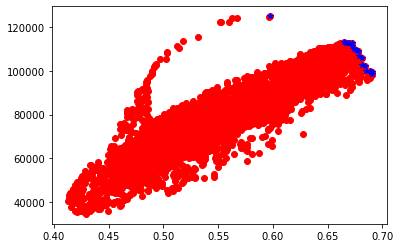

In [100]:
plt.plot(solutions[:,3], solutions[:,4], 'ro')
plt.plot(pareto_solutions[:,3], pareto_solutions[:,4], 'b*')
plt.show()

In [ ]:
print("updated spectral efficiency")
print(test.stpv_spectral_efficiency)

plt.plot(test.wavelength_array, test.thermal_emission_array, 'red')
plt.plot(test.wavelength_array, test.blackbody_spectrum, 'black')
plt.show()


